In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        
        return out

    def __radd__(self, other):
        return self + other

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        
        return out


    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')
    
        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward
    
        return out

    
    def __rmul__(self, other): # other * self
        return self * other


    def __truediv__(self, other): # self / other
        return self * other**-1

    def __neg__(self): # -self
        return self * -1
    
    def __sub__(self, other): # self - other
        return self + (-other)
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        
        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
    
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
    
        return out

    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
    
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()



In [3]:
a = Value(2.0)
b = Value(4.0)
a / b

Value(data=0.5)

In [4]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'


In [3]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})  # LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name=uid, label="{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name=uid + n._op, label=n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot


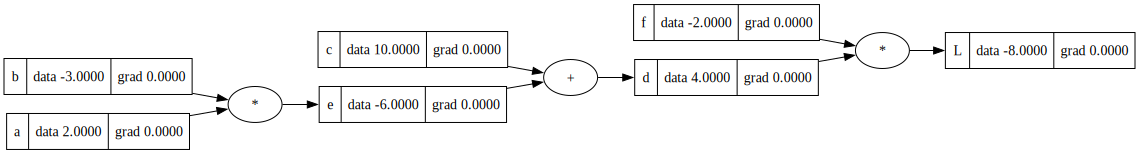

In [6]:
draw_dot(L)

In [6]:
a.grad = 6
b.grad = -4
c.grad = -2
e.grad = -2
d.grad = -2
f.grad = 4
L.grad = 1

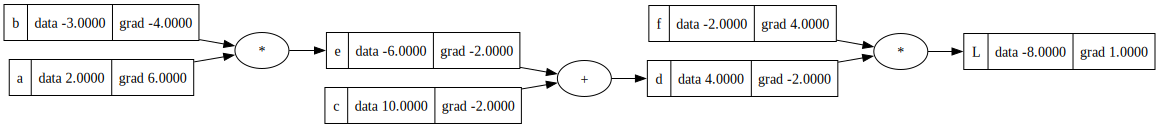

In [7]:
draw_dot(L)

In [8]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a * b
d = e + c
L = d * f

print(L.data)


-7.286496


In [9]:
def lol():
    h = 0.001
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L1 = L.data

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L2 = L.data

    print((L2 - L1)/h)

lol()


0.0


In [60]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()

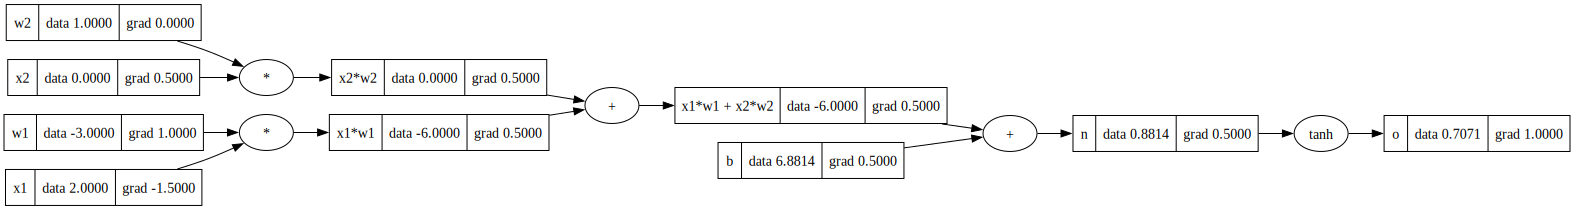

In [61]:
draw_dot(o)


In [45]:
o.backward()

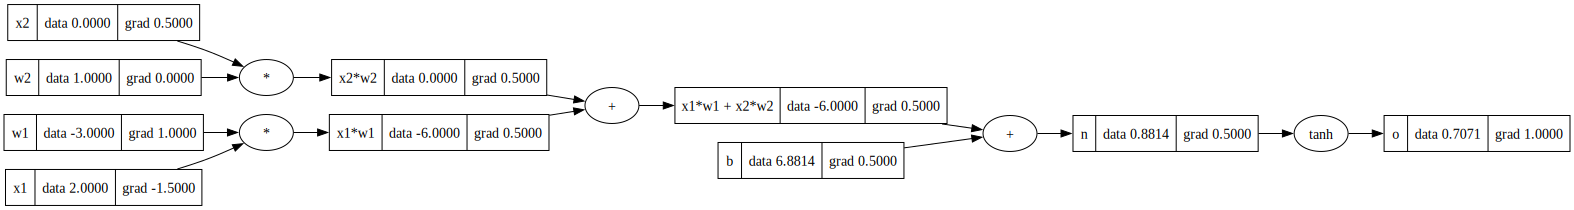

In [46]:
draw_dot(o)


In [35]:
o.grad = 1.0
o._backward()
n._backward()
b._backward()
x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()

In [40]:
o.grad = 1.0
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)

for node in reversed(topo):
    node._backward()

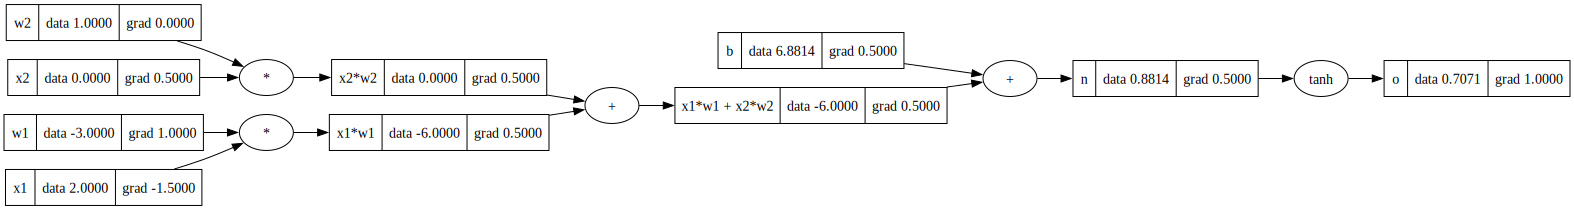

In [41]:
draw_dot(o)

In [23]:
o.grad = 1.0
n.grad = 0.5
x1w1x2w2.grad = 0.5
b.grad = 0.5
x1w1.grad = 0.5
x2w2.grad = 0.5
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

In [14]:
1 - o.data**2

0.4999999999999999

In [13]:
# o = tanh(n) 
# do/dn = 1 - tanh(n)² = 1 - o**2

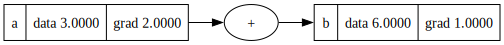

In [49]:
a = Value(3.0, label='a')
b = a + a ; b.label = 'b'
b.backward()
draw_dot(b)


In [70]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# -----
e = (2 * n).exp()
o = (e - 1) / (e + 1)
# -----
o.label = 'o'
o.backward()

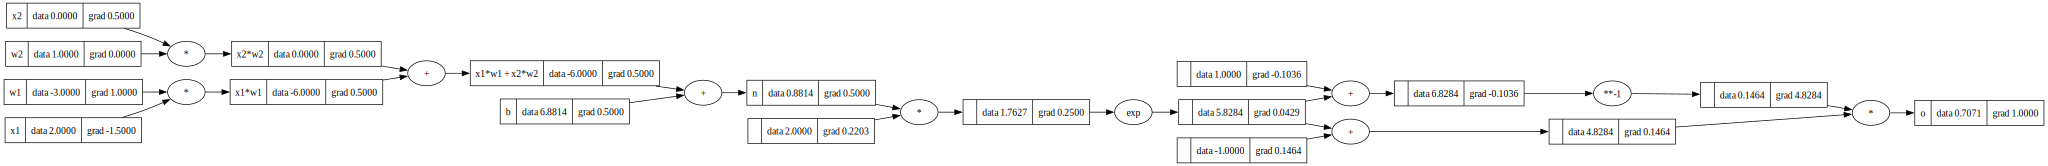

In [71]:
draw_dot(o)


In [4]:
import torch

In [5]:
x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double(); b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)


print(o.data.item())
o.backward()

print('----')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())


0.7071066904050358
----
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [6]:
o

tensor([0.7071], dtype=torch.float64, grad_fn=<TanhBackward0>)

In [7]:
torch.Tensor([[1, 2, 3], [4, 5, 6]])


tensor([[1., 2., 3.],
        [4., 5., 6.]])

In [8]:
torch.Tensor([2.0]).dtype

torch.float32

In [9]:
torch.Tensor([2.0]).double().dtype

torch.float64

In [10]:
import random

In [11]:
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        # w * x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]

class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]


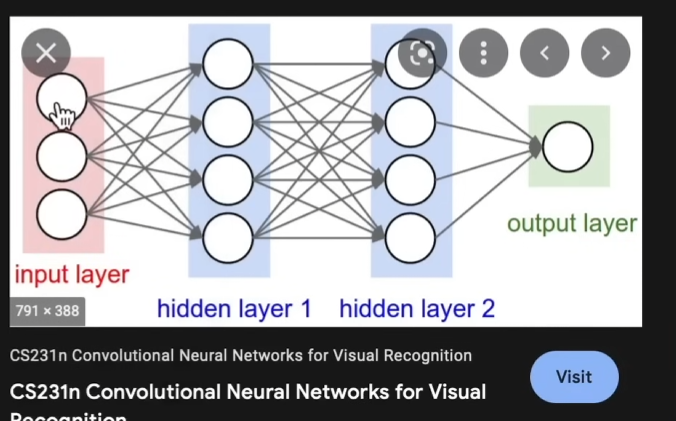

In [155]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)


Value(data=0.3989768901456397)

In [156]:
len(n.parameters())

41

In [157]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]

ys = [1.0, -1.0, -1.0, 1.0]  # desired targets



In [162]:
for k in range(20):
    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

    # backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()

    # update weights
    for p in n.parameters():
        p.data += -0.05 * p.grad
    print(k, loss.data)

0 0.027243154515420212
1 0.026440262593898003
2 0.02568153610480673
3 0.024963479665305172
4 0.02428295459628952
5 0.02363713474803788
6 0.023023468713542904
7 0.022439647379342755
8 0.0218835759561885
9 0.021353349785636272
10 0.02084723334210466
11 0.020363641949581183
12 0.019901125812987114
13 0.019458356030079244
14 0.01903411230369434
15 0.018627272118480396
16 0.01823680118286675
17 0.017861744967369177
18 0.017501221195573458
19 0.017154413165227284


In [163]:
ypred


[Value(data=0.9392433664959018),
 Value(data=-0.9248226912484342),
 Value(data=-0.9457886675033323),
 Value(data=0.9301963587748929)]